In [1]:
!pip install --quiet git+https://github.com/deepmind/dm-haiku

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as onp

import haiku as hk
from jax.experimental import optix

from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [3]:
#@title Real NVP stuffs
# Modified version of https://github.com/tensorflow/probability/blob/v0.10.0/tensorflow_probability/python/bijectors/real_nvp.py
# Includes minor modifications for compatibility with JAX, original license below
#===============================================================================
# Copyright 2018 The TensorFlow Probability Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Real NVP bijector."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as onp
import jax.numpy as jnp

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

bijector_lib = tfp.bijectors.bijector

__all__ = [
    'RealNVP'
]

class RealNVP(bijector_lib.Bijector):
  """RealNVP 'affine coupling layer' for vector-valued events.
  Real NVP models a normalizing flow on a `D`-dimensional distribution via a
  single `D-d`-dimensional conditional distribution [(Dinh et al., 2017)][1]:
  `y[d:D] = x[d:D] * tf.exp(log_scale_fn(x[0:d])) + shift_fn(x[0:d])`
  `y[0:d] = x[0:d]`
  The last `D-d` units are scaled and shifted based on the first `d` units only,
  while the first `d` units are 'masked' and left unchanged. Real NVP's
  `shift_and_log_scale_fn` computes vector-valued quantities. For
  scale-and-shift transforms that do not depend on any masked units, i.e.
  `d=0`, use the `tfb.Affine` bijector with learned parameters instead.
  Masking is currently only supported for base distributions with
  `event_ndims=1`. For more sophisticated masking schemes like checkerboard or
  channel-wise masking [(Papamakarios et al., 2016)[4], use the `tfb.Permute`
  bijector to re-order desired masked units into the first `d` units. For base
  distributions with `event_ndims > 1`, use the `tfb.Reshape` bijector to
  flatten the event shape.
  Recall that the MAF bijector [(Papamakarios et al., 2016)][4] implements a
  normalizing flow via an autoregressive transformation. MAF and IAF have
  opposite computational tradeoffs - MAF can train all units in parallel but
  must sample units sequentially, while IAF must train units sequentially but
  can sample in parallel. In contrast, Real NVP can compute both forward and
  inverse computations in parallel. However, the lack of an autoregressive
  transformations makes it less expressive on a per-bijector basis.
  A 'valid' `shift_and_log_scale_fn` must compute each `shift` (aka `loc` or
  'mu' in [Papamakarios et al. (2016)][4]) and `log(scale)` (aka 'alpha' in
  [Papamakarios et al. (2016)][4]) such that each are broadcastable with the
  arguments to `forward` and `inverse`, i.e., such that the calculations in
  `forward`, `inverse` [below] are possible. For convenience,
  `real_nvp_default_nvp` is offered as a possible `shift_and_log_scale_fn`
  function.
  NICE [(Dinh et al., 2014)][2] is a special case of the Real NVP bijector
  which discards the scale transformation, resulting in a constant-time
  inverse-log-determinant-Jacobian. To use a NICE bijector instead of Real
  NVP, `shift_and_log_scale_fn` should return `(shift, None)`, and
  `is_constant_jacobian` should be set to `True` in the `RealNVP` constructor.
  Calling `real_nvp_default_template` with `shift_only=True` returns one such
  NICE-compatible `shift_and_log_scale_fn`.
  The `bijector_fn` argument allows specifying a more general coupling relation,
  such as the LSTM-inspired activation from [5], or Neural Spline Flow [6].
  Caching: the scalar input depth `D` of the base distribution is not known at
  construction time. The first call to any of `forward(x)`, `inverse(x)`,
  `inverse_log_det_jacobian(x)`, or `forward_log_det_jacobian(x)` memoizes
  `D`, which is re-used in subsequent calls. This shape must be known prior to
  graph execution (which is the case if using tf.layers).
  #### Examples
  ```python
  tfd = tfp.distributions
  tfb = tfp.bijectors
  # A common choice for a normalizing flow is to use a Gaussian for the base
  # distribution. (However, any continuous distribution would work.) E.g.,
  nvp = tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
      bijector=tfb.RealNVP(
          num_masked=2,
          shift_and_log_scale_fn=tfb.real_nvp_default_template(
              hidden_layers=[512, 512])))
  x = nvp.sample()
  nvp.log_prob(x)
  nvp.log_prob(0.)
  ```
  For more examples, see [Jang (2018)][3].
  #### References
  [1]: Laurent Dinh, Jascha Sohl-Dickstein, and Samy Bengio. Density Estimation
       using Real NVP. In _International Conference on Learning
       Representations_, 2017. https://arxiv.org/abs/1605.08803
  [2]: Laurent Dinh, David Krueger, and Yoshua Bengio. NICE: Non-linear
       Independent Components Estimation. _arXiv preprint arXiv:1410.8516_,
       2014. https://arxiv.org/abs/1410.8516
  [3]: Eric Jang. Normalizing Flows Tutorial, Part 2: Modern Normalizing Flows.
       _Technical Report_, 2018. http://blog.evjang.com/2018/01/nf2.html
  [4]: George Papamakarios, Theo Pavlakou, and Iain Murray. Masked
       Autoregressive Flow for Density Estimation. In _Neural Information
       Processing Systems_, 2017. https://arxiv.org/abs/1705.07057
  [5]: Diederik P Kingma, Tim Salimans, Max Welling. Improving Variational
       Inference with Inverse Autoregressive Flow. In _Neural Information
       Processing Systems_, 2016. https://arxiv.org/abs/1606.04934
  [6]: Conor Durkan, Artur Bekasov, Iain Murray, George Papamakarios. Neural
       Spline Flows, 2019. http://arxiv.org/abs/1906.04032
  """

  def __init__(self,
               num_masked=None,
               fraction_masked=None,
               shift_and_log_scale_fn=None,
               bijector_fn=None,
               is_constant_jacobian=False,
               validate_args=False,
               name=None):
    """Creates the Real NVP or NICE bijector.
    Args:
      num_masked: Python `int`, indicating the number of units of the
        event that should should be masked. Must be in the closed interval
        `[0, D-1]`, where `D` is the event size of the base distribution.
        If the value is negative, then the last `d` units of the event are
        masked instead. Must be `None` if `fraction_masked` is defined.
      fraction_masked: Python `float`, indicating the number of units of the
        event that should should be masked. Must be in the closed interval
        `[-1, 1]`, and the value represents the fraction of the values to be
        masked. The final number of values to be masked will be the input size
        times the fraction, rounded to the the nearest integer towards zero.
        If negative, then the last fraction of units are masked instead. Must
        be `None` if `num_masked` is defined.
      shift_and_log_scale_fn: Python `callable` which computes `shift` and
        `log_scale` from both the forward domain (`x`) and the inverse domain
        (`y`). Calculation must respect the 'autoregressive property' (see class
        docstring). Suggested default
        `masked_autoregressive_default_template(hidden_layers=...)`.
        Typically the function contains `tf.Variables` and is wrapped using
        `tf.make_template`. Returning `None` for either (both) `shift`,
        `log_scale` is equivalent to (but more efficient than) returning zero.
      bijector_fn: Python `callable` which returns a `tfb.Bijector` which
        transforms the last `D-d` unit with the signature `(masked_units_tensor,
        output_units, **condition_kwargs) -> bijector`. The bijector must
        operate on scalar or vector events and must not alter the rank of its
        input.
      is_constant_jacobian: Python `bool`. Default: `False`. When `True` the
        implementation assumes `log_scale` does not depend on the forward domain
        (`x`) or inverse domain (`y`) values. (No validation is made;
        `is_constant_jacobian=False` is always safe but possibly computationally
        inefficient.)
      validate_args: Python `bool` indicating whether arguments should be
        checked for correctness.
      name: Python `str`, name given to ops managed by this object.
    Raises:
      ValueError: If both or none of `shift_and_log_scale_fn` and `bijector_fn`
          are specified.
    """
    parameters = dict(locals())
    name = name or 'real_nvp'
    with tf.name_scope(name) as name:
      # At construction time, we don't know input_depth.
      self._input_depth = None
      if num_masked is not None and fraction_masked is not None:
        raise ValueError('Exactly one of `num_masked` and '
                         '`fraction_masked` should be specified.')

      if num_masked is not None:
        if int(num_masked) != num_masked:
          raise TypeError('`num_masked` must be an integer. Got: {} of type {}'
                          ''.format(num_masked, type(num_masked)))
        self._num_masked = int(num_masked)
        self._fraction_masked = None
        self._reverse_mask = self._num_masked < 0
      else:
        if not np.issubdtype(type(fraction_masked), np.floating):
          raise TypeError('`fraction_masked` must be a float. Got: {} of type '
                          '{}'.format(fraction_masked, type(fraction_masked)))
        if np.abs(fraction_masked) >= 1.:
          raise ValueError(
              '`fraction_masked` must be in (-1, 1), but is {}.'.format(
                  fraction_masked))
        self._num_masked = None
        self._fraction_masked = float(fraction_masked)
        self._reverse_mask = self._fraction_masked < 0

      if shift_and_log_scale_fn is not None and bijector_fn is not None:
        raise ValueError('Exactly one of `shift_and_log_scale_fn` and '
                         '`bijector_fn` should be specified.')

      if shift_and_log_scale_fn:
        def _bijector_fn(x0, input_depth, **condition_kwargs):
          shift, log_scale = shift_and_log_scale_fn(x0, input_depth,
                                                    **condition_kwargs)
          return affine_scalar.AffineScalar(shift=shift, log_scale=log_scale)

        bijector_fn = _bijector_fn
      #
      # if validate_args:
      #   bijector_fn = _validate_bijector_fn(bijector_fn)

      # Still do this assignment for variable tracking.
      self._shift_and_log_scale_fn = shift_and_log_scale_fn
      self._bijector_fn = bijector_fn

      super(RealNVP, self).__init__(
          forward_min_event_ndims=1,
          is_constant_jacobian=is_constant_jacobian,
          validate_args=validate_args,
          parameters=parameters,
          name=name)

  @property
  def _masked_size(self):
    masked_size = (
        self._num_masked if self._num_masked is not None else int(
            np.round(self._input_depth * self._fraction_masked)))
    return masked_size

  def _cache_input_depth(self, x):
    if self._input_depth is None:
      self._input_depth = x.shape[-1]
      if self._input_depth is None:
        raise NotImplementedError(
            'Rightmost dimension must be known prior to graph execution.')

      if abs(self._masked_size) >= self._input_depth:
        raise ValueError(
            'Number of masked units {} must be smaller than the event size {}.'
            .format(self._masked_size, self._input_depth))

  def _bijector_input_units(self):
    return self._input_depth - abs(self._masked_size)

  def _forward(self, x, **condition_kwargs):
    self._cache_input_depth(x)

    x0, x1 = x[..., :self._masked_size], x[..., self._masked_size:]

    if self._reverse_mask:
      x0, x1 = x1, x0

    y1 = self._bijector_fn(x0, self._bijector_input_units(),
                           **condition_kwargs).forward(x1)

    if self._reverse_mask:
      y1, x0 = x0, y1

    y = tf.concat([x0, y1], axis=-1)
    return y

  def _inverse(self, y, **condition_kwargs):
    self._cache_input_depth(y)

    y0, y1 = y[..., :self._masked_size], y[..., self._masked_size:]

    if self._reverse_mask:
      y0, y1 = y1, y0

    x1 = self._bijector_fn(y0, self._bijector_input_units(),
                           **condition_kwargs).inverse(y1)

    if self._reverse_mask:
      x1, y0 = y0, x1

    x = tf.concat([y0, x1], axis=-1)
    return x

  def _forward_log_det_jacobian(self, x, **condition_kwargs):
    self._cache_input_depth(x)

    x0, x1 = x[..., :self._masked_size], x[..., self._masked_size:]

    if self._reverse_mask:
      x0, x1 = x1, x0

    return self._bijector_fn(x0, self._bijector_input_units(),
                             **condition_kwargs).forward_log_det_jacobian(
                                 x1, event_ndims=1)

  def _inverse_log_det_jacobian(self, y, **condition_kwargs):
    self._cache_input_depth(y)

    y0, y1 = y[..., :self._masked_size], y[..., self._masked_size:]

    if self._reverse_mask:
      y0, y1 = y1, y0

    return self._bijector_fn(y0, self._bijector_input_units(),
                             **condition_kwargs).inverse_log_det_jacobian(
                                 y1, event_ndims=1)

In [4]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

class NeuralSplineCoupling(hk.Module):
    def __init__(self, nunits, name, nbins=32):
        super(NeuralSplineCoupling, self).__init__(name=name)
        self.nunits = nunits
        self.nbins = nbins

    def bin_positions(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins])
        return jax.nn.softmax(x, axis=-1) *  (2. - self.nbins * 1e-2) + 1e-2

    def slopes(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins - 1])
        return jax.nn.softplus(x) + 1e-2

    def __call__(self, x, nunits):
        #net = jax.nn.leaky_relu(hk.Linear(128)(x))
        #net = jax.nn.leaky_relu(hk.Linear(128)(net))
        net = jnp.tanh(hk.Linear(128)(x))
        net = jnp.tanh(hk.Linear(128)(net))

        bin_widths = self.bin_positions(hk.Linear(nunits*self.nbins)(net))
        bin_heights = self.bin_positions(hk.Linear(nunits*self.nbins)(net))
        knot_slopes = self.slopes(hk.Linear(nunits*(self.nbins-1))(net))

        return tfb.RationalQuadraticSpline(
                bin_widths=bin_widths,
                bin_heights=bin_heights,
                knot_slopes=knot_slopes)


class NeuralSplineFlow(hk.Module):
    def __init__(self):
        super(NeuralSplineFlow, self).__init__()

    def __call__(self, x):
        spline1 = NeuralSplineCoupling(1, 'coupling1')
        spline2 = NeuralSplineCoupling(1, 'coupling2')
        spline3 = NeuralSplineCoupling(1, 'coupling3')

        # Computes the likelihood of these x
        chain = tfb.Chain([
            tfb.Scale(10),
            RealNVP(1, bijector_fn=spline1),
            tfb.Permute([1,0]),
            RealNVP(1, bijector_fn=spline2),
            tfb.Permute([1,0]),
            RealNVP(1, bijector_fn=spline3),
            tfb.Permute([1,0]),
            tfb.Scale(0.1)
        ])

        nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(2,))

        return nvp.log_prob(x), chain.inverse_log_det_jacobian(x, event_ndims=1, event_shape=(2,)), tfd.MultivariateNormalDiag([0., 0.], [1., 1.]).log_prob(chain.inverse(x))

##  Defining the analytic target distribution

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


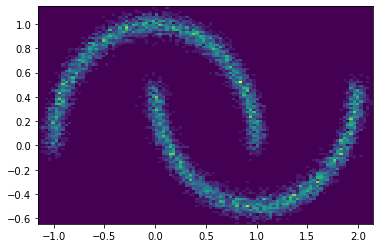

In [5]:
def get_two_moons(sigma, resolution=1024):
    """
    Returns two moons distribution as a TFP distribution
    Parameters
    ----------
    sigma: float
    Spread of the 2 moons distribution.
    resolution: int
    Number of components in the gaussian mixture approximation of the
    distribution (default: 1024)
    Returns
    -------
    distribution: TFP distribution
    Two moon distribution
    """

    outer_circ_x = np.cos(np.linspace(0, np.pi, resolution))
    outer_circ_y = np.sin(np.linspace(0, np.pi, resolution))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, resolution))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, resolution)) - .5

    X = np.append(outer_circ_x, inner_circ_x)
    Y = np.append(outer_circ_y, inner_circ_y)
    coords = np.vstack([X,Y])

    distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=np.ones(2*resolution)/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma)
    )
    return distribution

two_moons = get_two_moons(0.05)
distribution = two_moons

rng_key = jax.random.PRNGKey(seed=0)
samps = two_moons.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


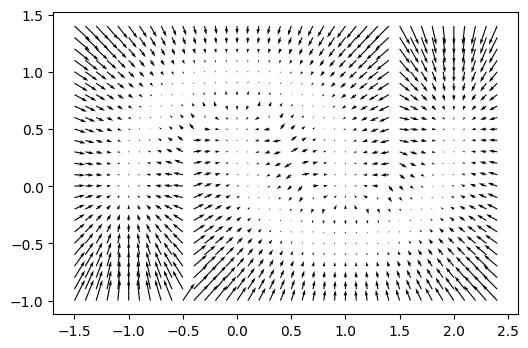

In [6]:
# But now we can also compute the gradients of log p :-)
true_score = jax.vmap(jax.grad(two_moons.log_prob))

# Close up
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = true_score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

## Learning the distribution with a Neural Spline Flow

In [7]:
def forwardNF(x):
    flow = NeuralSplineFlow()
    return flow(x)
             
model_NF = hk.transform(forwardNF, apply_rng=True)

In [8]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [9]:
batch_size = 512

def make_samples(rng_seq, n_samples, gm):
    return gm.sample(n_samples, seed = next(rng_seq))

def get_batch():
    x = make_samples(rng_seq, batch_size,distribution)
    return {'x': x}

In [10]:
@jax.jit
def loss_fn(params, rng_key, batch):
    log_prob, log_det, log_inv = model_NF.apply(params, rng_key, batch['x'])
    #log_prob = model_NF.apply(params, rng_key, batch['x'])
    return -jnp.mean(log_prob)

@jax.jit
def update(params, rng_key, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [11]:
params = model_NF.init(next(rng_seq), jnp.zeros((4, 2)))
opt_state = optimizer.init(params)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy redu

In [12]:
losses = []
for step in range(3000):
    batch = get_batch()
    loss, params, opt_state = update(params, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(loss)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy redu

2.4737506
1.1769195
0.9729587
0.83645797
0.7983645
0.59436315
0.69124734
0.5623257
0.5383258
0.48928094
0.5645586
0.710333
0.48791307
0.5425259
0.46177202
0.5019511
0.5061258
0.5472886
0.3785384
0.40299928
0.45244682
0.4172682
0.42136928
0.40309924
0.42317495
0.40676454
0.3891296
0.40042135
0.44383568
0.42648852


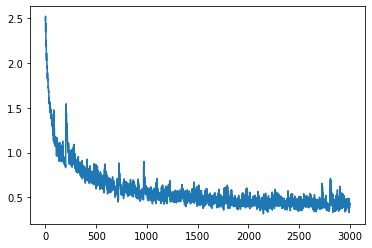

In [13]:
plt.plot(losses)

In [14]:
log_prob = partial(model_NF.apply, params, next(rng_seq))

In [15]:
def log_x_reshaped(x):
    log_prob_x, log_det, log_inv = log_prob(x)
    #log_prob_x = log_prob(x)
    return jnp.reshape(log_prob_x, ())

def log_det_reshaped(x):
    log_prob_x, log_det, log_inv = log_prob(x)
    return jnp.reshape(log_det, ())

def log_inv_reshaped(x):
    log_prob_x, log_det, log_inv = log_prob(x)
    return jnp.reshape(log_inv, ())

score_NF = jax.vmap(jax.grad(log_x_reshaped))
score_det = jax.vmap(jax.grad(log_det_reshaped))
score_inv = jax.vmap(jax.grad(log_inv_reshaped))

In [16]:
"""
scores = [score_NF, score_det, score_inv]
labels = ['NF', 'det', 'inv']

plt.figure(dpi=100)
scale = 4
offset = [0, 0]
display_score_error_two_moons(true_score, estimated_scores=scores,lpf=log_prob, labels=labels, distribution=None, 
                              is_amortized=False, is_reg=False, scale=scale, offset=offset, is_NF=True)
"""

"\nscores = [score_NF, score_det, score_inv]\nlabels = ['NF', 'det', 'inv']\n\nplt.figure(dpi=100)\nscale = 4\noffset = [0, 0]\ndisplay_score_error_two_moons(true_score, estimated_scores=scores,lpf=log_prob, labels=labels, distribution=None, \n                              is_amortized=False, is_reg=False, scale=scale, offset=offset, is_NF=True)\n"

In [17]:
def log_x_reshaped(x):
    x = x.reshape([1,-1])
    log_prob_x, log_det, log_inv = log_prob(x)
    #log_prob_x = log_prob(x)
    return jnp.reshape(log_prob_x, ())

def log_x_reshaped(x):
    x = x.reshape([1,-1])
    log_prob_x, log_det, log_inv = log_prob(x)
    #log_prob_x = log_prob(x)
    return jnp.reshape(log_prob_x, ())

def log_det_reshaped(x):
    x = x.reshape([1,-1])
    log_prob_x, log_det, log_inv = log_prob(x)
    return jnp.reshape(log_det, ())

def log_inv_reshaped(x):
    x = x.reshape([1,-1])
    log_prob_x, log_det, log_inv = log_prob(x)
    return jnp.reshape(log_inv, ())

score_NF = jax.vmap(jax.grad(log_x_reshaped))
score_det = jax.vmap(jax.grad(log_det_reshaped))
score_inv = jax.vmap(jax.grad(log_inv_reshaped))
log_prob = partial(model_NF.apply, params, next(rng_seq))

a, _, _ = log_prob(points)
lp = a.reshape([len(Y), len(X)])

X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy redu

In [18]:
g_NF = score_NF(points).reshape([len(Y), len(X),2])

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy redu

In [19]:
g_det = score_det(points).reshape([len(Y), len(X),2])

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy redu

In [20]:
g_inv = score_inv(points).reshape([len(Y), len(X),2])

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy redu

1152.619
825.04956
715.7608


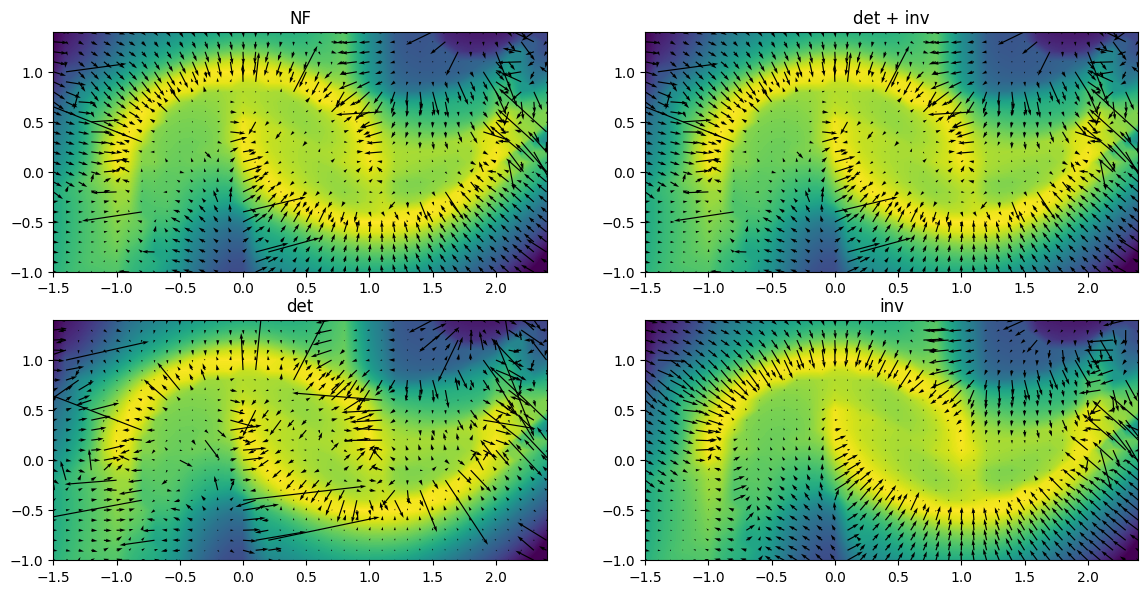

In [27]:
g_sum = g_det + g_inv

figure(figsize=(14,7), dpi=100)

plt.subplot(221)
contourf(X,Y,lp,256,vmin=-30)
quiver(X, Y, g_NF[:,:,0]/cte_norm, g_NF[:,:,1]/cte_norm);
plt.title('NF')

plt.subplot(222)
contourf(X,Y,lp,256,vmin=-30)
quiver(X, Y, g_sum[:,:,0]/cte_norm, g_sum[:,:,1]/cte_norm);
plt.title('det + inv')

plt.subplot(223)
contourf(X,Y,lp,256,vmin=-30)
quiver(X, Y, g_det[:,:,0]/cte_norm, g_det[:,:,1]/cte_norm);
plt.title('det')

plt.subplot(224)
contourf(X,Y,lp,256,vmin=-30)
quiver(X, Y, g_inv[:,:,0]/cte_norm, g_inv[:,:,1]/cte_norm);
plt.title('inv')

print(jnp.linalg.norm(g_NF))
print(jnp.linalg.norm(g_det))
print(jnp.linalg.norm(g_inv))